In [1]:
import os
if not os.path.exists('GTSRB'):
    !pip install -U -q torch_snippets
    !wget -qq https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
    !wget -qq https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
    !unzip -qq GTSRB_Final_Training_Images.zip
    !unzip -qq GTSRB_Final_Test_Images.zip
    !wget https://raw.githubusercontent.com/georgesung/traffic_sign_classification_german/master/signnames.csv
    !rm GTSRB_Final_Training_Images.zip GTSRB_Final_Test_Images.zip
    

--2023-08-13 16:20:41--  https://raw.githubusercontent.com/georgesung/traffic_sign_classification_german/master/signnames.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 999 [text/plain]
Saving to: ‘signnames.csv’

signnames.csv       100%[===================>]     999  --.-KB/s    in 0s      

2023-08-13 16:20:42 (34,6 MB/s) - ‘signnames.csv’ saved [999/999]



/home/lacie/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[08/13/23 16:21:34] INFO     29406                                          ]8;id=835091;file:///tmp/ipykernel_20222/524585188.py\524585188.py]8;;\:]8;id=462738;file:///tmp/ipykernel_20222/524585188.py#__init__:46\__init__:46]8;;\

                    INFO     9803                                           ]8;id=189186;file:///tmp/ipykernel_20222/524585188.py\524585188.py]8;;\:]8;id=12565;file:///tmp/ipykernel_20222/524585188.py#__init__:46\__init__:46]8;;\

EPOCH: 1.000  val_loss: 1.636  trn_acc: 0.295  trn_loss: 2.378  val_acc: 0.469  (9.08s - 354.08s remaining)
EPOCH: 2.000  val_loss: 0.943  trn_acc: 0.612  trn_loss: 1.178  val_acc: 0.688  (16.77s - 318.56s remaining)
EPOCH: 3.000  val_loss: 0.680  trn_acc: 0.751  trn_loss: 0.758  val_acc: 0.773  (24.45s - 301.52s remaining)
EPOCH: 4.000  val_loss: 0.579  trn_acc: 0.806  trn_loss: 0.592  val_acc: 0.811  (32.19s - 289.75s remaining)
EPOCH: 5.000  val_loss: 0.520  trn_acc: 0.835  trn_loss: 0.504  val_acc: 0.833  (40.00s - 279.99s remaining)
EPOCH: 6.000  val_loss: 0.493  trn_acc: 0.856  trn_loss: 0.442  val_acc: 0.842  (47.77s - 270.72s remaining)
EPOCH: 7.000  val_loss: 0.450  trn_acc: 0.868  trn_loss: 0.402  val_acc: 0.858  (55.52s - 261.75s remaining)
EPOCH: 8.000  val_loss: 0.431  trn_acc: 0.876  trn_loss: 0.382  val_acc: 0.866  (63.41s - 253.62s remaining)
EPOCH: 9.000  val_loss: 0.415  trn_acc: 0.885  trn_loss: 0.360  val_acc: 0.869  (71.42s - 246.01s remaining)
EPOCH: 10.000  val_l

100%|██████████| 141/141 [00:00<00:00, 145.24it/s]


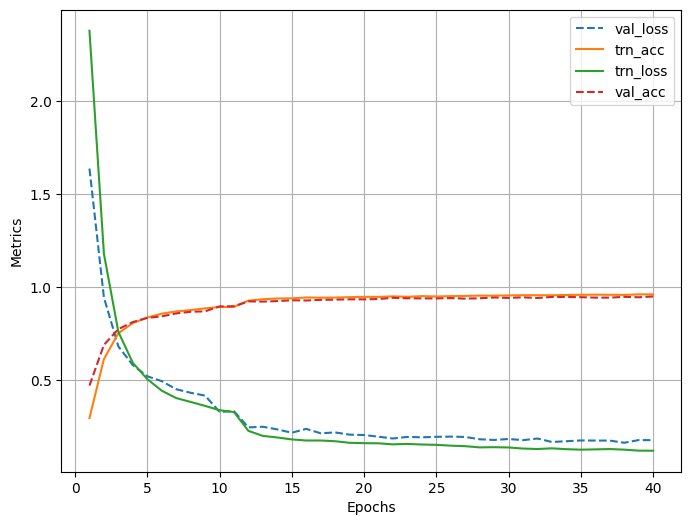

[08/13/23 16:26:57] INFO     Dumped object of size ≈2 MB @                 ]8;id=455324;file:///tmp/ipykernel_20222/524585188.py\524585188.py]8;;\:]8;id=729032;file:///tmp/ipykernel_20222/524585188.py#<module>:151\<module>:151]8;;\
                             "no-aug-no-bn.log" in 1.06e+00 seconds                                 

In [2]:
from torch_snippets import *
classIds = pd.read_csv('signnames.csv')
classIds.set_index('ClassId', inplace=True)
classIds = classIds.to_dict()['SignName']
classIds = {f'{k:05d}':v for k,v in classIds.items()}
id2int = {v:ix for ix,(k,v) in enumerate(classIds.items())}

from torchvision import transforms as T
classIds = pd.read_csv('signnames.csv')
classIds.set_index('ClassId', inplace=True)
classIds = classIds.to_dict()['SignName']
classIds = {f'{k:05d}':v for k,v in classIds.items()}
id2int = {v:ix for ix,(k,v) in enumerate(classIds.items())}

from torchvision import transforms as T

trn_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    # T.ColorJitter(brightness=(0.8,1.2), 
    # contrast=(0.8,1.2), 
    # saturation=(0.8,1.2), 
    # hue=0.25),
    # T.RandomAffine(5, translate=(0.01,0.1)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225]),
])

val_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225]),
])

class GTSRB(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform
        logger.info(len(self))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, ix):
        fpath = self.files[ix]
        clss = fname(parent(fpath))
        img = read(fpath, 1)
        return img, classIds[clss]

    def choose(self):
        return self[randint(len(self))]

    def collate_fn(self, batch):
        imgs, classes = list(zip(*batch))
        if self.transform:
            imgs = [self.transform(img)[None] for img in imgs]
        classes = [torch.tensor([id2int[clss]]) for clss in classes]
        imgs, classes = [torch.cat(i).to(device) for i in [imgs, classes]]
        return imgs, classes

device = 'cuda' if torch.cuda.is_available() else 'cpu'
all_files = Glob('GTSRB/Final_Training/Images/*/*.ppm')
np.random.seed(10)
np.random.shuffle(all_files)

from sklearn.model_selection import train_test_split
trn_files, val_files = train_test_split(all_files, random_state=1)

trn_ds = GTSRB(trn_files, transform=trn_tfms)
val_ds = GTSRB(val_files, transform=val_tfms)
trn_dl = DataLoader(trn_ds, 32, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, 32, shuffle=False, collate_fn=val_ds.collate_fn)

import torchvision.models as models

def convBlock(ni, no):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        #nn.BatchNorm2d(no),
        nn.MaxPool2d(2),
    )
    
class SignClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            convBlock(3, 64),
            convBlock(64, 64),
            convBlock(64, 128),
            convBlock(128, 64),
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),
            nn.Linear(256, len(id2int))
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def compute_metrics(self, preds, targets):
        ce_loss = self.loss_fn(preds, targets)
        acc = (torch.max(preds, 1)[1] == targets).float().mean()
        return ce_loss, acc
def train_batch(model, data, optimizer, criterion):
    ims, labels = data
    _preds = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    ims, labels = data
    _preds = model(ims)
    loss, acc = criterion(_preds, labels)
    return loss.item(), acc.item()
model = SignClassifier().to(device)
criterion = model.compute_metrics
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 40

log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')
        
    log.report_avgs(ex+1)
    if ex == 10: optimizer = optim.Adam(model.parameters(), lr=1e-4)

log.plot_epochs()
dumpdill(log, 'no-aug-no-bn.log')

[08/13/23 16:29:23] INFO     29406                                         ]8;id=606531;file:///tmp/ipykernel_20222/1621924306.py\1621924306.py]8;;\:]8;id=84771;file:///tmp/ipykernel_20222/1621924306.py#__init__:46\__init__:46]8;;\

                    INFO     9803                                          ]8;id=554603;file:///tmp/ipykernel_20222/1621924306.py\1621924306.py]8;;\:]8;id=272371;file:///tmp/ipykernel_20222/1621924306.py#__init__:46\__init__:46]8;;\

EPOCH: 1.000  val_loss: 0.542  trn_acc: 0.592  trn_loss: 1.366  val_acc: 0.823  (8.26s - 322.25s remaining)
EPOCH: 2.000  val_loss: 0.420  trn_acc: 0.864  trn_loss: 0.418  val_acc: 0.864  (16.66s - 316.60s remaining)
EPOCH: 3.000  val_loss: 0.286  trn_acc: 0.900  trn_loss: 0.301  val_acc: 0.905  (25.33s - 312.41s remaining)
EPOCH: 4.000  val_loss: 0.231  trn_acc: 0.926  trn_loss: 0.224  val_acc: 0.921  (34.02s - 306.22s remaining)
EPOCH: 5.000  val_loss: 0.196  trn_acc: 0.936  trn_loss: 0.193  val_acc: 0.938  (42.67s - 298.67s remaining)
EPOCH: 6.000  val_loss: 0.197  trn_acc: 0.944  trn_loss: 0.168  val_acc: 0.935  (51.19s - 290.09s remaining)
EPOCH: 7.000  val_loss: 0.165  trn_acc: 0.953  trn_loss: 0.142  val_acc: 0.948  (59.66s - 281.25s remaining)
EPOCH: 8.000  val_loss: 0.179  trn_acc: 0.955  trn_loss: 0.137  val_acc: 0.941  (67.95s - 271.80s remaining)
EPOCH: 9.000  val_loss: 0.163  trn_acc: 0.963  trn_loss: 0.113  val_acc: 0.950  (76.25s - 262.65s remaining)
EPOCH: 10.000  val_l

100%|██████████| 141/141 [00:01<00:00, 133.77it/s]


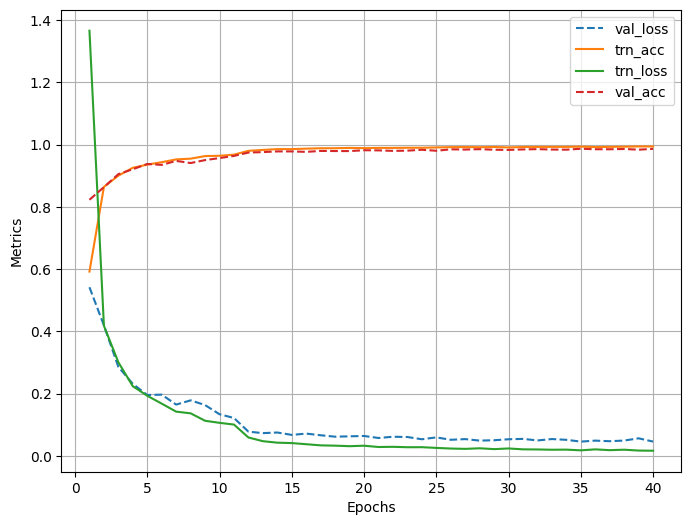

[08/13/23 16:35:03] INFO     Dumped object of size ≈2 MB @                ]8;id=682456;file:///tmp/ipykernel_20222/1621924306.py\1621924306.py]8;;\:]8;id=206441;file:///tmp/ipykernel_20222/1621924306.py#<module>:151\<module>:151]8;;\
                             "no-aug-yes-bn.log" in 8.70e-01 seconds                                

In [3]:
from torch_snippets import *
classIds = pd.read_csv('signnames.csv')
classIds.set_index('ClassId', inplace=True)
classIds = classIds.to_dict()['SignName']
classIds = {f'{k:05d}':v for k,v in classIds.items()}
id2int = {v:ix for ix,(k,v) in enumerate(classIds.items())}

from torchvision import transforms as T
classIds = pd.read_csv('signnames.csv')
classIds.set_index('ClassId', inplace=True)
classIds = classIds.to_dict()['SignName']
classIds = {f'{k:05d}':v for k,v in classIds.items()}
id2int = {v:ix for ix,(k,v) in enumerate(classIds.items())}

from torchvision import transforms as T

trn_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    # T.ColorJitter(brightness=(0.8,1.2), 
    # contrast=(0.8,1.2), 
    # saturation=(0.8,1.2), 
    # hue=0.25),
    # T.RandomAffine(5, translate=(0.01,0.1)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225]),
])

val_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225]),
])

class GTSRB(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform
        logger.info(len(self))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, ix):
        fpath = self.files[ix]
        clss = fname(parent(fpath))
        img = read(fpath, 1)
        return img, classIds[clss]

    def choose(self):
        return self[randint(len(self))]

    def collate_fn(self, batch):
        imgs, classes = list(zip(*batch))
        if self.transform:
            imgs = [self.transform(img)[None] for img in imgs]
        classes = [torch.tensor([id2int[clss]]) for clss in classes]
        imgs, classes = [torch.cat(i).to(device) for i in [imgs, classes]]
        return imgs, classes

device = 'cuda' if torch.cuda.is_available() else 'cpu'
all_files = Glob('GTSRB/Final_Training/Images/*/*.ppm')
np.random.seed(10)
np.random.shuffle(all_files)

from sklearn.model_selection import train_test_split
trn_files, val_files = train_test_split(all_files, random_state=1)

trn_ds = GTSRB(trn_files, transform=trn_tfms)
val_ds = GTSRB(val_files, transform=val_tfms)
trn_dl = DataLoader(trn_ds, 32, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, 32, shuffle=False, collate_fn=val_ds.collate_fn)

import torchvision.models as models

def convBlock(ni, no):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(no),
        nn.MaxPool2d(2),
    )
    
class SignClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            convBlock(3, 64),
            convBlock(64, 64),
            convBlock(64, 128),
            convBlock(128, 64),
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),
            nn.Linear(256, len(id2int))
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def compute_metrics(self, preds, targets):
        ce_loss = self.loss_fn(preds, targets)
        acc = (torch.max(preds, 1)[1] == targets).float().mean()
        return ce_loss, acc
def train_batch(model, data, optimizer, criterion):
    ims, labels = data
    _preds = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    ims, labels = data
    _preds = model(ims)
    loss, acc = criterion(_preds, labels)
    return loss.item(), acc.item()
model = SignClassifier().to(device)
criterion = model.compute_metrics
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 40

log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')
        
    log.report_avgs(ex+1)
    if ex == 10: optimizer = optim.Adam(model.parameters(), lr=1e-4)

log.plot_epochs()
dumpdill(log, 'no-aug-yes-bn.log')

In [ ]:
from torch_snippets import *
classIds = pd.read_csv('signnames.csv')
classIds.set_index('ClassId', inplace=True)
classIds = classIds.to_dict()['SignName']
classIds = {f'{k:05d}':v for k,v in classIds.items()}
id2int = {v:ix for ix,(k,v) in enumerate(classIds.items())}

from torchvision import transforms as T
classIds = pd.read_csv('signnames.csv')
classIds.set_index('ClassId', inplace=True)
classIds = classIds.to_dict()['SignName']
classIds = {f'{k:05d}':v for k,v in classIds.items()}
id2int = {v:ix for ix,(k,v) in enumerate(classIds.items())}

from torchvision import transforms as T

trn_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    T.ColorJitter(brightness=(0.8,1.2), 
    contrast=(0.8,1.2), 
    saturation=(0.8,1.2), 
    hue=0.25),
    T.RandomAffine(5, translate=(0.01,0.1)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225]),
])

val_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225]),
])

class GTSRB(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform
        logger.info(len(self))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, ix):
        fpath = self.files[ix]
        clss = fname(parent(fpath))
        img = read(fpath, 1)
        return img, classIds[clss]

    def choose(self):
        return self[randint(len(self))]

    def collate_fn(self, batch):
        imgs, classes = list(zip(*batch))
        if self.transform:
            imgs = [self.transform(img)[None] for img in imgs]
        classes = [torch.tensor([id2int[clss]]) for clss in classes]
        imgs, classes = [torch.cat(i).to(device) for i in [imgs, classes]]
        return imgs, classes

device = 'cuda' if torch.cuda.is_available() else 'cpu'
all_files = Glob('GTSRB/Final_Training/Images/*/*.ppm')
np.random.seed(10)
np.random.shuffle(all_files)

from sklearn.model_selection import train_test_split
trn_files, val_files = train_test_split(all_files, random_state=1)

trn_ds = GTSRB(trn_files, transform=trn_tfms)
val_ds = GTSRB(val_files, transform=val_tfms)
trn_dl = DataLoader(trn_ds, 32, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, 32, shuffle=False, collate_fn=val_ds.collate_fn)

import torchvision.models as models

def convBlock(ni, no):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(no),
        nn.MaxPool2d(2),
    )
    
class SignClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            convBlock(3, 64),
            convBlock(64, 64),
            convBlock(64, 128),
            convBlock(128, 64),
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),
            nn.Linear(256, len(id2int))
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def compute_metrics(self, preds, targets):
        ce_loss = self.loss_fn(preds, targets)
        acc = (torch.max(preds, 1)[1] == targets).float().mean()
        return ce_loss, acc
def train_batch(model, data, optimizer, criterion):
    ims, labels = data
    _preds = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    ims, labels = data
    _preds = model(ims)
    loss, acc = criterion(_preds, labels)
    return loss.item(), acc.item()
model = SignClassifier().to(device)
criterion = model.compute_metrics
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 40

log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')
        
    log.report_avgs(ex+1)
    if ex == 10: optimizer = optim.Adam(model.parameters(), lr=1e-4)

log.plot_epochs()
dumpdill(log, '40-yes-aug-yes-bn.log')
from google.colab import files
files.download('40-yes-aug-yes-bn.log')

2020-09-17 09:54:30.795 | INFO     | torch_snippets.loader:Glob:172 - 39209 files found at GTSRB/Final_Training/Images/*/*.ppm
2020-09-17 09:54:30.808 | INFO     | __main__:__init__:46 - 29406
2020-09-17 09:54:30.809 | INFO     | __main__:__init__:46 - 9803


EPOCH: 1.000	trn_loss: 1.840	trn_acc: 0.462	val_loss: 0.752	val_acc: 0.762	(62.07s - 2420.80s remaining)
EPOCH: 2.000	trn_loss: 0.679	trn_acc: 0.780	val_loss: 0.432	val_acc: 0.858	(125.57s - 2385.74s remaining)
EPOCH: 3.000	trn_loss: 0.480	trn_acc: 0.845	val_loss: 0.369	val_acc: 0.878	(189.63s - 2338.78s remaining)
EPOCH: 4.000	trn_loss: 0.397	trn_acc: 0.871	val_loss: 0.299	val_acc: 0.902	(253.21s - 2278.87s remaining)
EPOCH: 5.000	trn_loss: 0.341	trn_acc: 0.889	val_loss: 0.267	val_acc: 0.911	(316.45s - 2215.16s remaining)
EPOCH: 6.000	trn_loss: 0.297	trn_acc: 0.905	val_loss: 0.246	val_acc: 0.920	(379.64s - 2151.27s remaining)
EPOCH: 7.000	trn_loss: 0.269	trn_acc: 0.910	val_loss: 0.218	val_acc: 0.930	(442.87s - 2087.82s remaining)
EPOCH: 8.000	trn_loss: 0.250	trn_acc: 0.918	val_loss: 0.198	val_acc: 0.934	(506.33s - 2025.32s remaining)
EPOCH: 9.000	trn_loss: 0.230	trn_acc: 0.923	val_loss: 0.198	val_acc: 0.938	(569.49s - 1961.58s remaining)
EPOCH: 10.000	trn_loss: 0.211	trn_acc: 0.930	va

2020-09-17 09:35:05.018 | INFO     | torch_snippets.loader:Glob:172 - 4 files found at *.log
  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 20/20 [00:00<00:00, 351.47it/s]



EPOCH: 20.000	trn_loss: 0.031	trn_acc: 0.990	val_loss: 0.077	val_acc: 0.978	(8455.42s - 0.00s remaining)


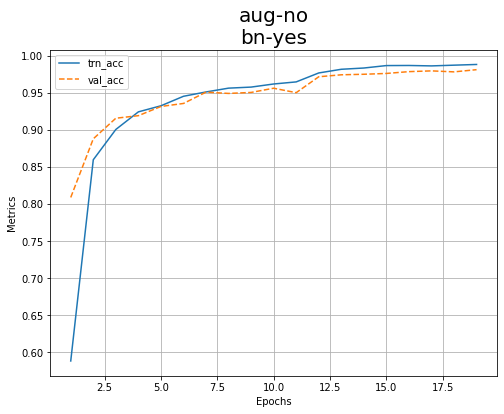

100%|██████████| 20/20 [00:00<00:00, 358.36it/s]



EPOCH: 20.000	trn_loss: 0.391	trn_acc: 0.869	val_loss: 0.323	val_acc: 0.889	(9196.88s - 0.00s remaining)


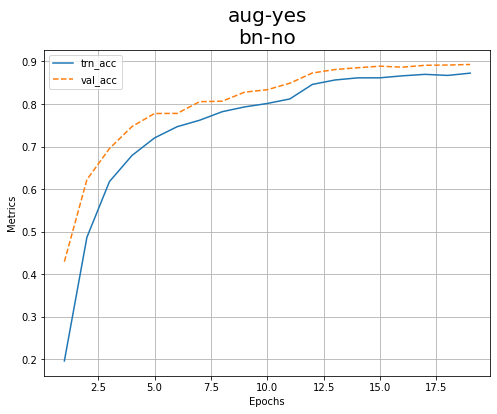

100%|██████████| 20/20 [00:00<00:00, 372.78it/s]



EPOCH: 20.000	trn_loss: 0.094	trn_acc: 0.969	val_loss: 0.093	val_acc: 0.969	(8106.35s - 0.00s remaining)


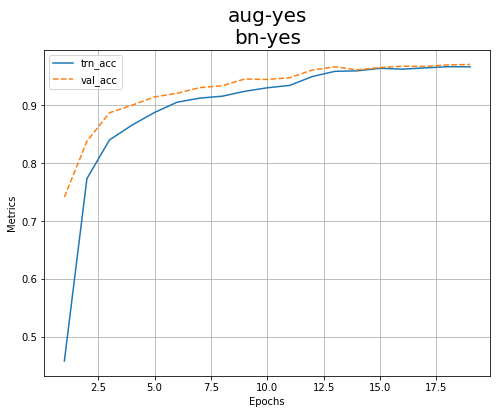

100%|██████████| 20/20 [00:00<00:00, 330.28it/s]



EPOCH: 20.000	trn_loss: 0.146	trn_acc: 0.952	val_loss: 0.202	val_acc: 0.938	(7348.78s - 0.00s remaining)


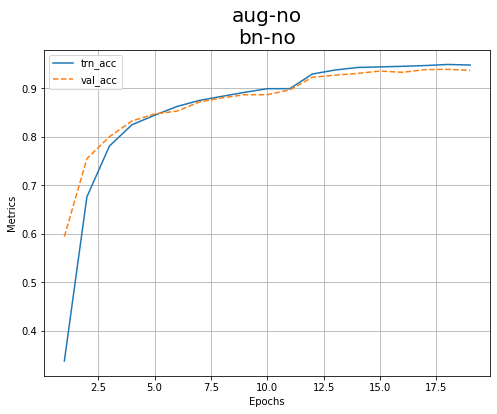

In [ ]:
for f in Glob('*.log'):
    log = loaddill(f)
    print()
    log.report_avgs(20)
    log.plot_epochs(['trn_acc', 'val_acc'], title=f.replace(',','\n').replace('.log',''))
    print()
    line()